In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

### Data

In [2]:
features, labels = make_moons(n_samples=5000, random_state=42, noise=0.1)

In [3]:
features.shape, labels.shape

((5000, 2), (5000,))

In [4]:
features[:5]

array([[-0.1196884 ,  1.03684845],
       [ 0.03370055,  0.2493631 ],
       [ 0.03864294,  0.33033539],
       [ 0.22222051,  1.03355193],
       [ 0.74448612,  0.69288687]])

In [5]:
labels[:5]

array([0, 1, 1, 0, 0], dtype=int64)

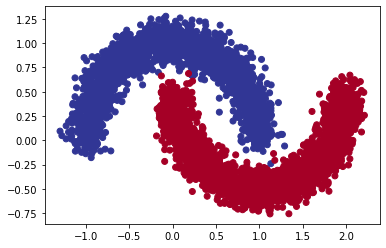

In [6]:
plt.scatter(features[:,0], features[:,1], c = labels, cmap = plt.cm.RdYlBu_r)

In [7]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # The examples are read at random, in no particular order
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        j = tf.constant(indices[i: min(i + batch_size, num_examples)])
        yield tf.gather(features, j), tf.gather(labels, j)

In [8]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tf.Tensor(
[[ 0.81542541 -0.5208196 ]
 [ 1.87023608  0.14413456]
 [ 1.26105072 -0.38811667]
 [ 0.02628615  0.33867943]
 [ 1.07696486  0.20406091]
 [ 1.04023348  0.06259715]
 [ 0.39479576 -0.08226579]
 [ 0.42870268  0.97003057]
 [-0.7975599   0.57112803]
 [ 1.87373439  0.27476226]], shape=(10, 2), dtype=float64) 
 tf.Tensor([1 1 1 1 0 0 1 0 0 1], shape=(10,), dtype=int64)


### Initializing Model Parameters

In [9]:
num_inputs = 2
num_outputs = 2
num_hiddens = 200

W1 = tf.Variable(tf.random.normal(shape=(num_inputs, num_hiddens), mean=0, stddev=0.01))
b1 = tf.Variable(tf.zeros(num_hiddens))
W2 = tf.Variable(tf.random.normal(shape=(num_hiddens, num_hiddens), mean=0, stddev=0.01))
b2 = tf.Variable(tf.random.normal([num_hiddens], stddev=.01))
W3 = tf.Variable(tf.random.normal(shape=(num_hiddens, num_outputs), mean=0, stddev=0.01))
b3 = tf.Variable(tf.random.normal([num_outputs], stddev=.01))

params = [W1, b1, W2, b2, W3, b3]

In [10]:
W1.shape, b1.shape, W2.shape, b2.shape, W3.shape, b3.shape

(TensorShape([2, 200]),
 TensorShape([200]),
 TensorShape([200, 200]),
 TensorShape([200]),
 TensorShape([200, 2]),
 TensorShape([2]))

### Softmax Activation

In [10]:
def softmax(X):
    X_exp = tf.exp(X)
    partition = tf.reduce_sum(X_exp, 1, keepdims=True)
    return X_exp / partition  # The broadcasting mechanism is applied here

### ReLU Activation

In [11]:
def relu(X):
    return tf.math.maximum(X, 0)

### Defining $L_2$ Norm Penalty

In [12]:
def l2_penalty(w):
    return tf.reduce_sum(tf.pow(w, 2)) / 2

### Defining the Model

In [13]:
def net(X, dropout1, dropout2):
    X = tf.reshape(tf.cast(X, dtype=tf.float32), (-1, num_inputs))
    H1 = relu(tf.matmul(X, W1) + b1)
    H1 = dropout_layer(H1, dropout1)
    H2 = relu(tf.matmul(H1, W2) + b2)
    H2 = dropout_layer(H2, dropout2)
    return softmax(tf.matmul(H2, W3) + b3)

### Loss Function

In [14]:
def cross_entropy(y_hat, y):
    return -tf.math.log(tf.boolean_mask(y_hat, tf.one_hot(y, depth=y_hat.shape[-1])))

### Optimization

In [15]:
def sgd(params, grads, lr, batch_size):
    """Minibatch stochastic gradient descent.
    Defined in :numref:`sec_linear_scratch`"""
    for param, grad in zip(params, grads):
        param.assign_sub(lr*grad/batch_size)

### Dropout

In [16]:
def dropout_layer(X, dropout):
    assert 0 <= dropout <= 1
    # In this case, all elements are dropped out
    if dropout == 1:
        return tf.zeros_like(X)
    # In this case, all elements are kept
    if dropout == 0:
        return X
    mask = tf.random.uniform(
        shape=tf.shape(X), minval=0, maxval=1) < 1 - dropout
    return tf.cast(mask, dtype=tf.float32) * X / (1.0 - dropout)

### Training

In [17]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, random_state=42)

In [18]:
num_epochs = 10
lr = 0.1
loss = cross_entropy
lambd = 0.01
dropout1, dropout2 = 0.2, 0.5

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, X_train, y_train):
        # Compute gradients and update parameters
        with tf.GradientTape() as tape:
            y_hat = net(X, dropout1, dropout2)
            l = loss(y_hat, y) + lambd * l2_penalty(W1) + lambd * l2_penalty(W2) + lambd * l2_penalty(W3)
        # Compute gradient on l with respect to [`w`, `b`]
        grads = tape.gradient(l, params)
        # Update parameters using their gradient
        sgd(params, grads, lr, batch_size)

### Decision Boundary

In [21]:
def plot_decision_boundary(net, X, y):
    # Define the axis boundaries of the plot and create a meshgrid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                       np.linspace(y_min, y_max, 100))
    # Create X values (we're going to predict on all of these)
    x_in = np.c_[xx.ravel(), yy.ravel()] 
    # Make predictions using the trained model
    y_pred = np.array(net(x_in, 0, 0)).argmax(axis=1)
    # Check for multi-class
    if y_pred[0].size > 1:
        print("doing multiclass classification...")
        # We have to reshape our predictions to get them ready for plotting
        y_pred = np.argmax(y_pred, axis=1).reshape(xx.shape)
    else:
        print("doing binary classifcation...")
        y_pred = np.round(y_pred).reshape(xx.shape)
    # Plot decision boundary
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

doing binary classifcation...


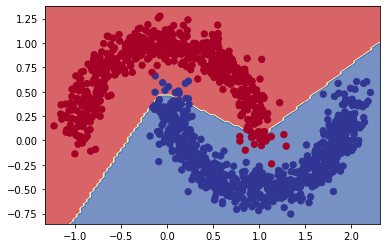

In [22]:
plot_decision_boundary(net, X_test, y_test)